#### Tune Parameters

Modules

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Activation, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from kerastuner.tuners import BayesianOptimization

seed = 444 # random number seed

#### Utilities function

In [2]:
def plot_confusion_matrix(the_pred, 
                          the_true, 
                          save_plot=False, 
                          the_path=None):
    # generate confusion matrix
    confusion_matrix = metrics.confusion_matrix(the_pred, the_true)
    
    # generate the plot
    plot_df = pd.DataFrame(confusion_matrix, index=["0", "1"], columns=["0", "1"])
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(plot_df, annot=True, cmap="YlGnBu", fmt="g", ax=ax)
    plt.xticks(rotation=30)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    
    # if save plot
    if save_plot == True:
        fig.savefig(the_path, dpi=500)   

def model_performance(y_test,y_pred):
    res = pd.DataFrame()
    res['accuracy'] = [metrics.accuracy_score(y_test,y_pred)]
    res['Down_precision'] = [metrics.classification_report(y_test,y_pred,
                                                   output_dict=True)['0']['precision']]
    res['Up_precision'] = [metrics.classification_report(y_test,y_pred,output_dict=True)['1']['precision']]
    res['f1_score'] = [metrics.f1_score(y_test,y_pred,average='weighted')]
    res['recall_score'] = [metrics.recall_score(y_test,y_pred,average='weighted')]
    return res

Load data

In [3]:
data_path = os.path.dirname(os.getcwd())
data_path = os.path.join(data_path, "Data/features.csv")
data = pd.read_csv(data_path)

data = data[data["Date"] < "2020-01-01"]
del data["Date"]
data_y = data.pop("direction").values
data_x = data.values

Normalize the data: 0 mean and unit variance

In [4]:
# extract categorical features
condition_macd = data.columns == "macd"
macd = data_x[:, condition_macd]
data_x_nomalized = data_x[:, [not i for i in condition_macd]]  # all features except macd

# normalized
scaler = StandardScaler()
data_x_nomalized =  scaler.fit_transform(data_x_nomalized)

# append macd
data_x_nomalized = np.hstack((data_x_nomalized, macd))

##### Boosting tree: xgboost

Convert data to xgboost format

In [5]:
# train-validation split
trainX, validationX, trainY, validationY = train_test_split(
                                                                data_x_nomalized,
                                                                data_y,
                                                                train_size=0.8,
                                                                random_state=seed
                                                            )
# convert to xgboost format
trainX_xg = xgb.DMatrix(trainX, label=trainY) # TODO delete
validationX_xg = xgb.DMatrix(validationX, label=validationY) # TODO delete

Use the grid search to find the best params

In [ ]:
# set up param grid
eta = [0.1, 0.015, 0.01, 0.0015, 0.001]
gamma = [0.5, 1.0, 1.5, 2.0, 2.5, 0]
max_depth = [i for i in range(1, 20)]
boosting_rounds = [i for i in range(2, 51)]
parameters = {
    "n_estimators": boosting_rounds,
    "learning_rate": eta,
    "gamma": gamma,
    "max_depth": max_depth
}

# set up classifier
xgboost_classifier = xgb.XGBClassifier(objective="binary:logistic")
xg_gridSearch = GridSearchCV(
    xgboost_classifier,
    parameters,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1,
)

# find params
xg_gridSearch.fit(trainX, trainY)

# extract tuned model
xgboost_tuned = xg_gridSearch.best_estimator_
with open(os.path.join(os.getcwd(), "models/xgboost.pickle"), 'wb') as f:
    pickle.dump(xgboost_tuned, f)

# print
print("Best Params:")
print(xg_gridSearch.best_params_)
print("Best Score:")
print(xg_gridSearch.best_score_)

# Best Params:
# {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 24}
# Best Score:
# 0.7090909090909092

Model performance on validation dataset

In [ ]:
# load pickle
with open(os.path.join(os.getcwd(), "models/xgboost.pickle"), "rb") as f:
    xgboost_tuned = pickle.load(f)

# generate prediction on validation dataset
xgboost_pred = xgboost_tuned.predict(validationX)
xgboost_pred = [1 if i >= 0.5 else 0 for i in xgboost_pred]

# confusion matrix
xgboost_confusion_matrix = plot_confusion_matrix(xgboost_pred, 
                                                 validationY,
                                                save_plot=True,
                                                the_path=os.path.join(os.getcwd(), "confusion_matrix/xgboost.png"))

# model performance form
xgboost_performance = model_performance(validationY, xgboost_pred)
print(xgboost_performance)

#    accuracy  Down_precision  Up_precision  f1_score  recall_score
# 0  0.547619        0.666667      0.527778  0.481481      0.547619

#### LSTM

Preprocess the data

In [6]:
# one-hot encoding
data_shape = data_x_nomalized.shape
# one-hot encoding for macd
macd = data_x_nomalized[:, data_shape[1] - 1]
data_x_nomalized = data_x_nomalized[:, :data_shape[1] - 1]
macd = to_categorical(macd, num_classes=2)
data_x_nomalized = np.hstack((data_x_nomalized, macd))
# one-hot encoding for label
data_y_encoded = to_categorical(data_y, num_classes=2)

# split to train and test
trainX, validationX, trainY, validationY = train_test_split(
                                                                data_x_nomalized,
                                                                data_y_encoded,
                                                                train_size=0.8,
                                                                random_state=seed
                                                            )

In [7]:
# special steps for LSTM models: reshape input to be [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
validationX = validationX.reshape(validationX.shape[0], 1, validationX.shape[1])

Build model functions:

In [8]:
# build model
def build_model_LSTM(hp):
    # model
    model = Sequential()
    
    # input layer
    input_num_unit= hp.Int("input_layer_units", 50, 100, 10)
    input_drop_ratio = hp.Float("input_layer_dropRatio", 0.0, 0.5, 0.1)
    model.add(LSTM(units=input_num_unit, input_shape=(1, 27), return_sequences=True))
    model.add(Dropout(input_drop_ratio))

    # layer set
    # LSTM layers set 1
    num_layers_1 = hp.Int("num_layers_set_1", 0, 3)
    num_units_1 = hp.Int("num_units_set_1", 50, 100, 10)
    dropRatio_1 = hp.Float("dropRatio_set_1", 0.0, 0.5, 0.1)
    for i in range(num_layers_1):
        model.add(LSTM(units=num_units_1, return_sequences=True))
        model.add(Dropout(dropRatio_1))

    # LSTM layer set 2
    num_layers_2 = hp.Int("num_layers_set_2", 0, 3)
    num_units_2 = hp.Int("num_units_set_2", 10, 50, 10)
    dropRatio_2 = hp.Float("dropRatio_set_2", 0.0, 0.5, 0.1)
    for i in range(num_layers_2):
        model.add(LSTM(units=num_units_2, return_sequences=True))
        model.add(Dropout(dropRatio_2))
    
    # LSTM last layer
    num_units_3 = hp.Int("num_units_set_3", 10, 50, 10)
    model.add(LSTM(units=num_units_3, return_sequences=False))
    
    # output layer
    model.add(Dense(2, activation='sigmoid'))

    # tune learning rate
    lr = hp.Choice("lr", values=[0.1, 0.015, 0.01, 0.0015, 0.001])
    model.compile(
        optimizer=Adam(learning_rate=lr), loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

Bayesian Optimization, tune best hyperparam

In [9]:
tuner_LSTM = BayesianOptimization(
    build_model_LSTM,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=3,
    directory=os.getcwd(),
    project_name="tune_LSTM",
    overwrite = False
)

tuner_LSTM.search(
    x=trainX,
    y=trainY,
    verbose=1,
    epochs=100,
    batch_size=30,
    validation_data=(validationX, validationY)
)

INFO:tensorflow:Reloading Oracle from existing project /Users/lihaohang/Desktop/FE-595-Final/Models_train/tune_LSTM/oracle.json
INFO:tensorflow:Reloading Tuner from /Users/lihaohang/Desktop/FE-595-Final/Models_train/tune_LSTM/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [10]:
# show summary
tuner_LSTM.results_summary()

In [11]:
# show best
tuner_LSTM.get_best_hyperparameters()[0].values

{'input_layer_units': 60,
 'input_layer_dropRatio': 0.30000000000000004,
 'num_layers_set_1': 1,
 'num_units_set_1': 80,
 'dropRatio_set_1': 0.30000000000000004,
 'num_layers_set_2': 2,
 'num_units_set_2': 30,
 'dropRatio_set_2': 0.30000000000000004,
 'num_units_set_3': 20,
 'lr': 0.01}

Cross-validation

In [12]:
# build best model function
def build_best_LSTM():
    # model
    model = Sequential()
    
    # input layer
    model.add(LSTM(units=60, input_shape=(1, 27), return_sequences=True))
    model.add(Dropout(0.3))

    # layer set
    # LSTM layers set 1
    for i in range(1):
        model.add(LSTM(units=80, return_sequences=True))
        model.add(Dropout(0.3))

    # LSTM layer set 2
    for i in range(2):
        model.add(LSTM(units=30, return_sequences=True))
        model.add(Dropout(0.3))
    
    # LSTM last layer
    model.add(LSTM(units=20, return_sequences=False))
    
    # output layer
    model.add(Dense(2, activation='sigmoid'))

    # tune learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

build_best_LSTM().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 60)             21120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 60)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 80)             45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 80)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 30)             13320     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 30)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 30)            

In [13]:
# cross validation
cv_split = KFold(n_splits=5, random_state=seed, shuffle=True)

LSTM_accuracy = []
for train_index, validation_index in cv_split.split(trainX):
    # current train and test set
    cur_trainX = trainX[train_index]
    cur_trainY = trainY[train_index]
    cur_validationX = trainX[validation_index]
    cur_validationY = trainY[validation_index]
    
    # fit the model
    model = build_best_LSTM()
    model.fit(cur_trainX, cur_trainY, epochs=100, batch_size=30, verbose=0)
    
    # predict
    cur_pred = np.argmax(model.predict(cur_validationX), axis=-1) # convert prob to classes
    
    # accuracy
    cur_accuracy = metrics.accuracy_score(np.argmax(cur_validationY, axis=-1), cur_pred)
    
    # append result
    LSTM_accuracy.append(cur_accuracy)
    
# output
print("Accuracy:", round(np.mean(LSTM_accuracy), 6), "+-", round(np.std(LSTM_accuracy), 6))
# Accuracy: 0.642424 +- 0.08221

Accuracy: 0.593939 +- 0.089072


Model performance

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /Users/lihaohang/Desktop/FE-595-Final/Models_train/models/LSTM/assets
   accuracy  Down_precision  Up_precision  f1_score  recall_score
0  0.595238        0.611111      0.583333  0.593162      0.595238


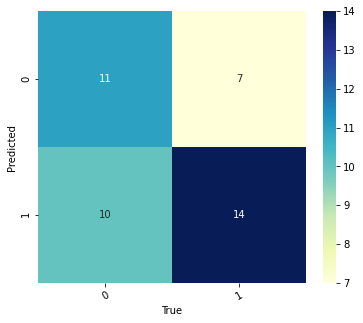

In [14]:
# save model
model = build_best_LSTM()
model.fit(trainX, trainY, epochs=100, batch_size=30, verbose=0)
LSTM_pred = np.argmax(model.predict(validationX), axis=-1)
model.save(os.path.join(os.getcwd(), "models/LSTM"))

# confusion matrix
LSTM_confusion_matrix = plot_confusion_matrix(LSTM_pred, 
                                                np.argmax(validationY, axis=-1),
                                                save_plot=True,
                                                the_path=os.path.join(os.getcwd(), "confusion_matrix/LSTM.png"))

# model performance form
LSTM_performance = model_performance(np.argmax(validationY, axis=-1), LSTM_pred)
print(LSTM_performance)

ANN Model

Restore the test and train data:

In [15]:
trainX = trainX.reshape(trainX.shape[0], trainX.shape[2])
validationX = validationX.reshape(validationX.shape[0], validationX.shape[2])

Build model function:

In [16]:
def build_model_ANN(hp):
    # model
    model = Sequential()
    model.add(Input(shape=(27,)))

    # tune layers
    # dense layers set 1
    num_layers_1 = hp.Int("n_layers_1", 0, 3)
    num_units_1 = hp.Int("n_units_1", 50, 100, 10)
    for i in range(num_layers_1):
        model.add(Dense(num_units_1))
        model.add(Activation("relu"))

    # dense layer set 2
    num_layers_2 = hp.Int("n_layers_2", 0, 3)
    num_units_2 = hp.Int("n_units_2", 10, 50, 10)
    for i in range(num_layers_2):
        model.add(Dense(num_units_2))
        model.add(Activation("relu"))

    # output layer
    model.add(Dense(2, activation="sigmoid"))

    # tune learning rate
    lr = hp.Choice("lr", values=[0.1, 0.015, 0.01, 0.0015, 0.001])
    model.compile(
        optimizer=Adam(learning_rate=lr), loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

Bayesian Optimization, tune best hyperparam

In [17]:
tuner_ANN = BayesianOptimization(
    build_model_ANN,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=3,
    directory=os.getcwd(),
    project_name="tune_ANN",
    overwrite = False
)

tuner_ANN.search(
    x=trainX,
    y=trainY,
    verbose=1,
    epochs=100,
    batch_size=30,
    validation_data=(validationX, validationY)
)

INFO:tensorflow:Reloading Oracle from existing project /Users/lihaohang/Desktop/FE-595-Final/Models_train/tune_ANN/oracle.json
INFO:tensorflow:Reloading Tuner from /Users/lihaohang/Desktop/FE-595-Final/Models_train/tune_ANN/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [18]:
# show summary
tuner_ANN.results_summary()

In [19]:
# show best param
tuner_ANN.get_best_hyperparameters()[0].values

{'n_layers_1': 1,
 'n_units_1': 50,
 'n_layers_2': 2,
 'n_units_2': 20,
 'lr': 0.0015}

Cross-validation

In [20]:
def build_best_ANN():
    # model
    model = Sequential()
    model.add(Input(shape=(27,)))

    # dense layers set 1
    for i in range(1):
        model.add(Dense(50))
        model.add(Activation("relu"))

    # dense layer set 2
    for i in range(2):
        model.add(Dense(20))
        model.add(Activation("relu"))

    # output layer
    model.add(Dense(2, activation="sigmoid"))

    # tune learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0015), loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

build_best_ANN().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1400      
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

In [21]:
# cross validation
cv_split = KFold(n_splits=5, random_state=seed, shuffle=True)

ANN_accuracy = []
for train_index, validation_index in cv_split.split(trainX):
    # current train and test set
    cur_trainX = trainX[train_index]
    cur_trainY = trainY[train_index]
    cur_validationX = trainX[validation_index]
    cur_validationY = trainY[validation_index]
    
    # fit the model
    model = build_best_ANN()
    model.fit(cur_trainX, cur_trainY, epochs=100, batch_size=30, verbose=0)
    
    # predict
    cur_pred = np.argmax(model.predict(cur_validationX), axis=-1) # convert prob to classes
    
    # accuracy
    cur_accuracy = metrics.accuracy_score(np.argmax(cur_validationY, axis=-1), cur_pred)
    
    # append result
    ANN_accuracy.append(cur_accuracy)
    
# output
print("Accuracy:", round(np.mean(ANN_accuracy), 6), "+-", round(np.std(ANN_accuracy), 6))
# Accuracy: 0.624242 +- 0.09697

Accuracy: 0.630303 +- 0.110762


Model performance

INFO:tensorflow:Assets written to: /Users/lihaohang/Desktop/FE-595-Final/Models_train/models/ANN/assets
   accuracy  Down_precision  Up_precision  f1_score  recall_score
0  0.595238        0.590909           0.6  0.595009      0.595238


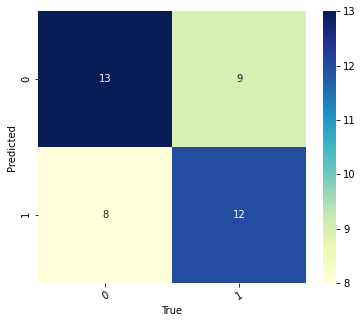

In [22]:
# save model
model = build_best_ANN()
model.fit(trainX, trainY, epochs=100, batch_size=30, verbose=0)
ANN_pred = np.argmax(model.predict(validationX), axis=-1)
model.save(os.path.join(os.getcwd(), "models/ANN"))

# confusion matrix
ANN_confusion_matrix = plot_confusion_matrix(ANN_pred, 
                                            np.argmax(validationY, axis=-1),
                                            save_plot=True,
                                            the_path=os.path.join(os.getcwd(), "confusion_matrix/ANN.png"))

# model performance form
ANN_performance = model_performance(np.argmax(validationY, axis=-1), ANN_pred)
print(ANN_performance)